from https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from datasets import load_dataset

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 32, shuffle = True)

In [49]:
# get dataset from hugging face
dataset_hf = load_dataset("mnist", split='train').with_format("torch")
loader_hf = torch.utils.data.DataLoader(dataset = dataset, batch_size = 32, shuffle = True)

Found cached dataset mnist (/Users/skelley/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


In [3]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 10
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 10),
		)
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 10 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(10, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 28 * 28),
			torch.nn.Sigmoid()
		)
	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded

In [4]:
# Model Initialization
model = AE()
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-8)

In [6]:
epochs = 3
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader:
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28)
        # Output of Autoencoder
        reconstructed = model(image)
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Storing the losses in a list for plotting
        losses.append(loss)
        outputs.append((epochs, image, reconstructed))
    print(f'epoch {epoch} loss={loss}')

epoch 0 loss=0.01782197132706642
epoch 1 loss=0.01458184327930212
epoch 2 loss=0.015713267028331757


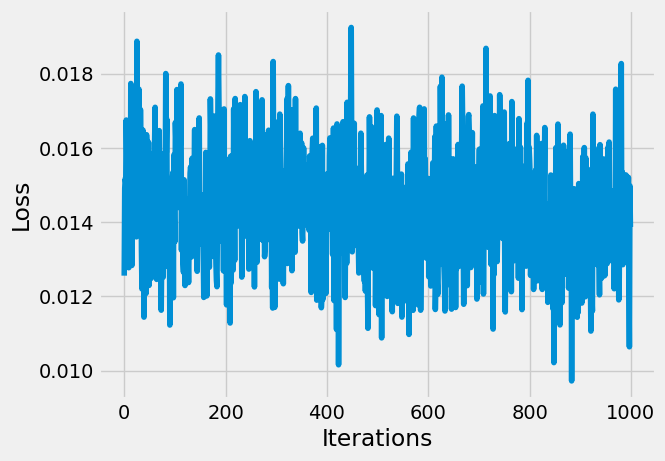

In [50]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
with torch.no_grad():
    plt.plot(losses[-1000:])
torch.save(model.state_dict(), "./saved_models/mnist_ae_pytorch.pth")

In [51]:
model = AE()
model.load_state_dict(torch.load( "./saved_models/mnist_ae_pytorch.pth"))

<All keys matched successfully>

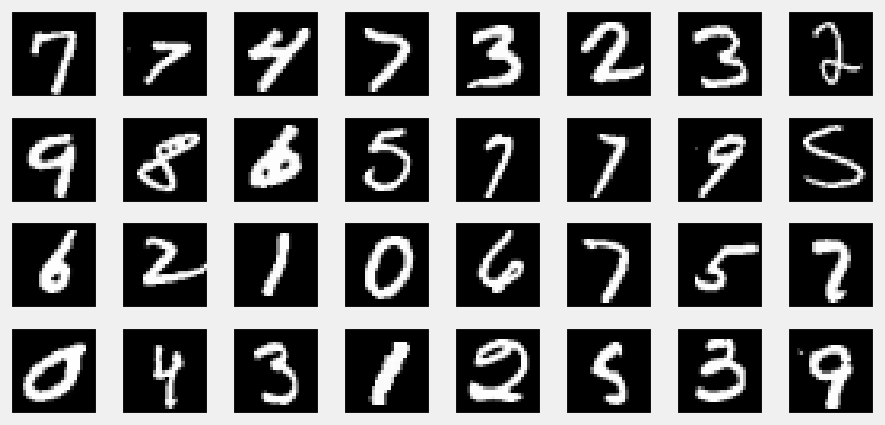

In [52]:
# show the first test batch
test = datasets.MNIST(root = "./data", train = False, download = True, transform = tensor_transform)
test_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 32, shuffle = True)
first_batch = next(iter(test_loader))
fig = plt.figure(figsize=(10,5))
for j in range(len(first_batch[0])):
    ax = fig.add_subplot(4,8, j+1, xticks=[], yticks=[])
    ax.imshow(first_batch[0][j][0].numpy(), cmap='gray')

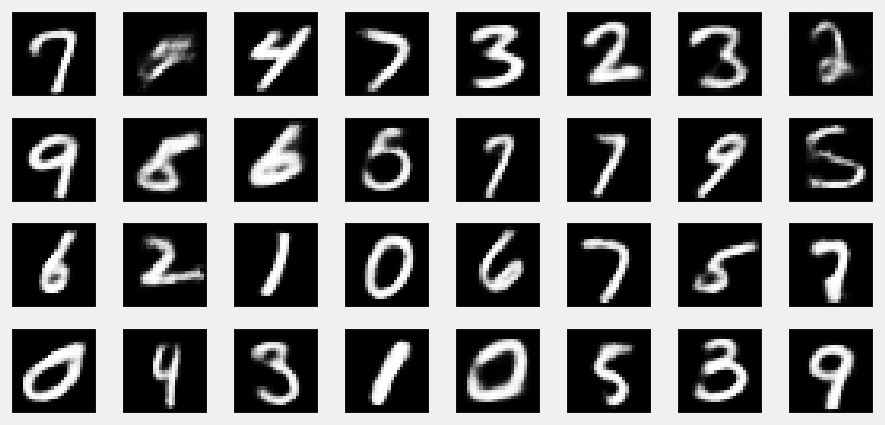

In [53]:
# run first batch through the model to confirm it looks much the same
fig = plt.figure(figsize=(10,5))
with torch.no_grad():
    for j in range(len(first_batch[0])):
        ax = fig.add_subplot(4,8, j+1, xticks=[], yticks=[])
        recon = model(first_batch[0][j][0].flatten())
        recon_image = torch.unflatten(recon, 0, (28,28))
        ax.imshow(recon_image.numpy(), cmap='gray')

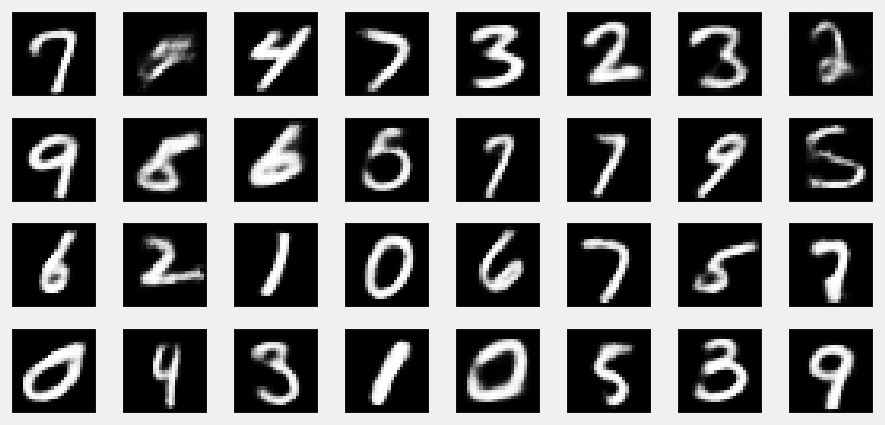

In [54]:
# run the first batch through the encoder and then decoder to get the same thing
fig = plt.figure(figsize=(10,5))
with torch.no_grad():
    for j in range(len(first_batch[0])):
        ax = fig.add_subplot(4,8, j+1, xticks=[], yticks=[])
        representation = model.encoder(first_batch[0][j][0].flatten())
        image = model.decoder(representation)
        recon_image = torch.unflatten(image, 0, (28,28))
        ax.imshow(recon_image.numpy(), cmap='gray')